# Extração de grafos de conhecimento de bulas de medicamentos de arquivos PDF extraídos do bulário eletrônico da ANVISA


**Materiais úteis**
- [Preparing PDFs for RAGs: um comparativo entre bibliotecas](https://towardsdatascience.com/preparing-pdfs-for-rags-b1579fc697f1/)
- [Build a knowledge graph from documents using Docling](https://alain-airom.medium.com/build-a-knowledge-graph-from-documents-using-docling-8bc05e1389f7)
- [Comprehensive Guide to Chunking in LLM and RAG Systems](https://kshitijkutumbe.medium.com/comprehensive-guide-to-chunking-in-llm-and-rag-systems-c579a11ce6e2)
- [Building Knowledge Graphs with LLM Graph Transformer](https://medium.com/data-science/building-knowledge-graphs-with-llm-graph-transformer-a91045c49b59)
- [How to construct knowledge graphs](https://python.langchain.com/docs/how_to/graph_constructing/)
- [Geração com Recuperação Aumentada (RAG) em
Grafos de Conhecimento](https://books-sol.sbc.org.br/index.php/sbc/catalog/download/153/658/1179?inline=1)

In [4]:
!python3 -m spacy download pt_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 21.2 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_md')


In [8]:
from src.config import RAW_DATA_DIR, PROCESSED_DATA_DIR
from src.data_processing.pdf_and_markdown_pipeline import PdfAndMarkdownPipeline
from src.data_processing.chunks import HEADERS_TO_SPLIT_ON

from src.utils.gen_ai_connection import LLMModel
from src.kg.kg_from_text import KGFromText
from langchain_experimental.graph_transformers import LLMGraphTransformer


FILE_NAME = "bula_1748876242121.pdf"
PDF_FILE_PATH = f"{RAW_DATA_DIR}/{FILE_NAME}"
MD_FILE_PATH = f"{PROCESSED_DATA_DIR}/{FILE_NAME}.md"


chunk_size = 400
chunk_overlap = 100
headers_to_split_on = HEADERS_TO_SPLIT_ON

provider = "openai"
temperature = 0.7
max_tokens = None

In [2]:
pdf_md_pipeline = PdfAndMarkdownPipeline()

In [ ]:
# Executar somente quando for converter um pdf para markdown
pdf_md_pipeline.pdf_to_markdown(
    source_file_path=PDF_FILE_PATH,
    dest_dir_path=PROCESSED_DATA_DIR
)

In [3]:
pdf_md_pipeline.load_markdown(
    source_file_path=MD_FILE_PATH
)
pdf_md_pipeline.md_documents

INFO:src.data_processing.pdf_and_markdown_pipeline:Document /home/marilia/git/pos/tcc_ufg_akcit_nlp/data/processed/bula_1748876242121.pdf.md loaded.


[Document(metadata={'source': '/home/marilia/git/pos/tcc_ufg_akcit_nlp/data/processed/bula_1748876242121.pdf.md'}, page_content="paracetamol\n\nAché Laboratórios Farmacêuticos S.A. C omprimidos revestidos 750 mg\n\nBULA PARA PACIENTE\n\nBula de acordo com a Resolução-RDC nº 47/2009\n\nI.IDENTIFICAÇÃO DO MEDICAMENTO\n\nparacetamol\n\nMedicamento Genérico Lei nº 9.787, de 1999\n\nAPRESENTAÇÕES\n\nComprimidos revestidos de 750 mg: embalagens com 20 ou 200 comprimidos.\n\nUSO ORAL\n\nUSO ADULTO E PEDIÁTRICO ACIMA DE 12 ANOS\n\nCOMPOSIÇÃO\n\nCada comprimido revestido contém:\n\nparacetamol..........................................................................................................................................750 mg\n\nExcipientes: povidona, amidoglicolato de sódio, amido, ácido esteárico, álcool polivinílico, macrogol, talco e dióxido de titânio.\n\nII. INFORMAÇÕES AO PACIENTE\n\n1. PARA QUE ESTE MEDICAMENTO É INDICADO?\n\nEste medicamento é indicado para a redução da febre 

In [4]:
pdf_md_pipeline.get_chunks(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    headers_to_split_on=headers_to_split_on,
)
pdf_md_pipeline.chunk_documents

[Document(metadata={}, page_content='paracetamol  \nAché Laboratórios Farmacêuticos S.A. C omprimidos revestidos 750 mg  \nBULA PARA PACIENTE  \nBula de acordo com a Resolução-RDC nº 47/2009  \nI.IDENTIFICAÇÃO DO MEDICAMENTO  \nparacetamol  \nMedicamento Genérico Lei nº 9.787, de 1999  \nAPRESENTAÇÕES  \nComprimidos revestidos de 750 mg: embalagens com 20 ou 200 comprimidos.  \nUSO ORAL  \nUSO ADULTO E PEDIÁTRICO ACIMA DE 12 ANOS'),
 Document(metadata={}, page_content='USO ORAL  \nUSO ADULTO E PEDIÁTRICO ACIMA DE 12 ANOS  \nCOMPOSIÇÃO  \nCada comprimido revestido contém:  \nparacetamol..........................................................................................................................................750 mg  \nExcipientes: povidona, amidoglicolato de sódio, amido, ácido esteárico, álcool polivinílico, macrogol, talco e dióxido de titânio.'),
 Document(metadata={}, page_content='II. INFORMAÇÕES AO PACIENTE  \n1. PARA QUE ESTE MEDICAMENTO É INDICADO?  \nEste medicamen

In [5]:
llm = LLMModel(
    provider=provider,
    temperature=temperature,
    max_tokens=max_tokens
).llm

kg = KGFromText(
    llm=llm
)

In [6]:
pdf_md_pipeline.chunk_documents[5]

Document(metadata={}, page_content='4. O QUE DEVO SABER ANTES DE USAR ESTE MEDICAMENTO?  \nVocê não deve tomar mais do que a dose recomendada (superdose) para provocar maior alívio, pois pode causar sérios problemas de saúde. Você deve consultar seu médico se a dor ou febre continuar ou piorar, ou se surgirem novos sintomas, pois estes sintomas podem ser sinais de doenças graves.')

In [9]:
chunk_documents = [pdf_md_pipeline.chunk_documents[5]]   

llm_gt = LLMGraphTransformer(llm=llm)
graph_documents = await llm_gt.aconvert_to_graph_documents(chunk_documents)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [10]:
graph_documents

[GraphDocument(nodes=[Node(id='Medicamento', type='Medicamento', properties={}), Node(id='Dosagem_Recomendada', type='Dose', properties={}), Node(id='Problemas_De_Saude', type='Problema de saúde', properties={}), Node(id='Sintomas', type='Sintoma', properties={}), Node(id='Medico', type='Pessoa', properties={}), Node(id='Doencas_Graves', type='Doença', properties={})], relationships=[Relationship(source=Node(id='Medicamento', type='Medicamento', properties={}), target=Node(id='Dosagem_Recomendada', type='Dose', properties={}), type='DEVE_SEGUIR', properties={}), Relationship(source=Node(id='Dosagem_Recomendada', type='Dose', properties={}), target=Node(id='Problemas_De_Saude', type='Problema de saúde', properties={}), type='PODE_CAUSAR', properties={}), Relationship(source=Node(id='Sintomas', type='Sintoma', properties={}), target=Node(id='Doencas_Graves', type='Doença', properties={}), type='PODEM_SER_SINAIS_DE', properties={}), Relationship(source=Node(id='Sintomas', type='Sintoma', 

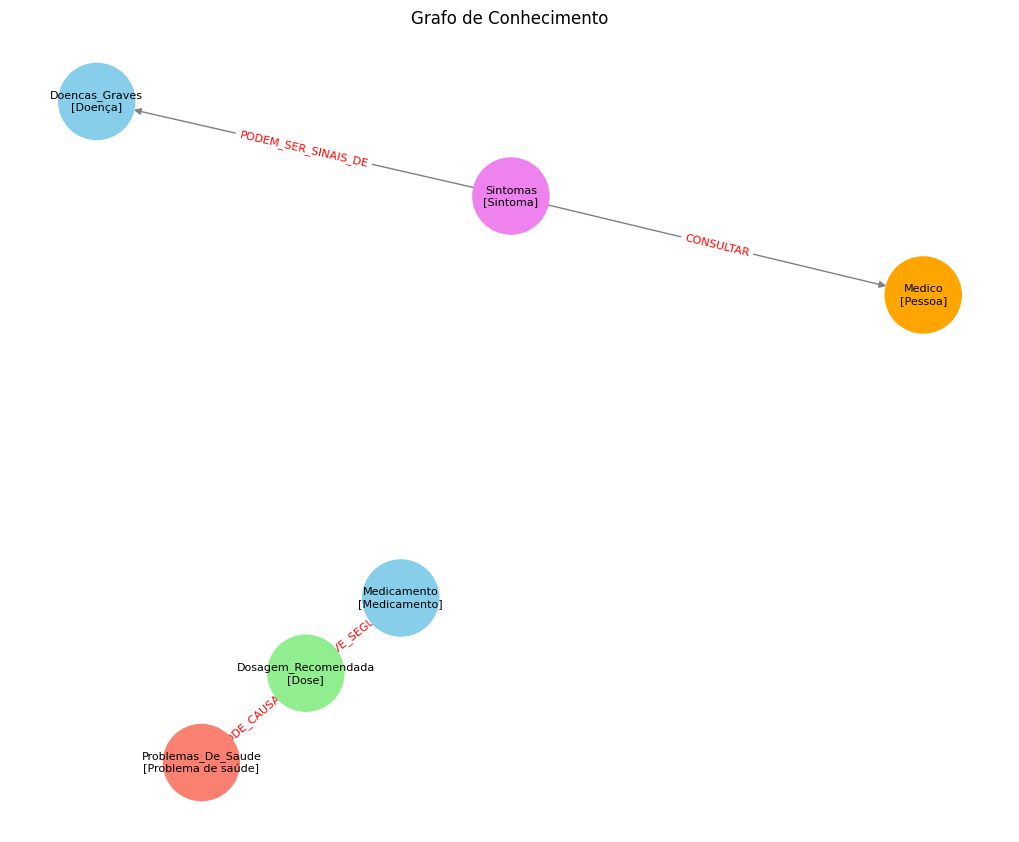

In [11]:
from src.utils.dataviz import export_graph_documment_to_html, plot_graph_documents

plot_graph_documents(graph_docs=graph_documents)
export_graph_documment_to_html(graph_docs=graph_documents, file_name=FILE_NAME)

## O código abaixo ainda precisa ser trabalhado

In [7]:
chunk_documents = [pdf_md_pipeline.chunk_documents[5]]

kg.graph_documents(
    chunk_documents=chunk_documents
)

TypeError: 'NoneType' object is not callable

In [ ]:
kg.graph_documents

In [ ]:
figsize=(10, 8), 
show_node_properties=False

kg.plot_and_save_graph(
    file_name=FILE_NAME,
    figsize=figsize, 
    show_node_properties=show_node_properties
)